In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## STEP 1: Load and Explore Data

In [2]:
retail = pd.read_csv("online_retail_II.csv")

In [3]:
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
retail.shape

(1067371, 8)

In [5]:
print("number of unique customers:", retail['Customer ID'].nunique())

number of unique customers: 5942


In [6]:
#checking duplicates
print(f"there are {retail.duplicated().sum()} duplicated rows")

there are 34335 duplicated rows


In [7]:
#viewing duplicated rows
retail[retail.duplicated()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
390,489517,84951A,S/4 PISTACHIO LOVEBIRD COASTERS,1,2009-12-01 11:34:00,2.55,16329.0,United Kingdom
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
394,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
657,489529,22028,PENNY FARTHING BIRTHDAY CARD,12,2009-12-01 11:51:00,0.42,17984.0,United Kingdom
658,489529,22036,DINOSAUR BIRTHDAY CARD,12,2009-12-01 11:51:00,0.42,17984.0,United Kingdom


Note: After manual review, there are indeed lots of duplicated rows (e.g. row 371 and 394). Let's remove them.

In [8]:
retail = retail.drop_duplicates(keep='first')

In [9]:
#checking missing values
retail.isna().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               0
Customer ID    235151
Country             0
dtype: int64

Note: there are 234007 rows without Customer ID. Since we are working at the customer level, we cannot aggregate these columns. Let's remove them from further analysis.

In [10]:
retail = retail[retail['Customer ID'].notna()]

In [12]:
# checking types of columns
retail.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

## STEP 2: Calculate Cohort Index

InvoiceDate column is encoded as object. We need to transform it into datatime type to be able to extract monthly data.

In [113]:
retail.InvoiceDate = pd.to_datetime(retail.InvoiceDate.astype(str), format="%Y-%m-%d %H:%M:%S")

In [114]:
# retain only year and month
retail.loc[:, 'InvoiceMonth'] = retail.loc[:, 'InvoiceDate'].dt.to_period('M')
retail['InvoiceMonth'].head()

0    2009-12
1    2009-12
2    2009-12
3    2009-12
4    2009-12
Name: InvoiceMonth, dtype: period[M]

In [116]:
# converting PeriodArray back to timestamp
retail['InvoiceMonth'] = retail['InvoiceMonth'].apply(lambda x: x.to_timestamp())
retail['InvoiceMonth'].head()

0   2009-12-01
1   2009-12-01
2   2009-12-01
3   2009-12-01
4   2009-12-01
Name: InvoiceMonth, dtype: datetime64[ns]

### Assigning acquisition month cohort for each customer:

In [16]:
retail.loc[:, 'CohortMonth'] = retail.groupby('Customer ID')['InvoiceMonth'].transform('min')

In [17]:
retail.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,2011-12-01,2011-08-01


### Calculating Cohort Index

In [18]:
def get_date_int(df, col):
    '''Helper function to extract year and month from the column (col) from a dataframe (df)'''
    
    year = df[col].map(lambda x: x.year)
    month = df[col].map(lambda x: x.month)
    
    return year, month

In [19]:
def get_cohort_index(df, transaction_col, cohort_col):
    '''
    Calculates Cohort Index based on monthly data
    
    Input: 
        df: dataframe
        transaction_col: column with which time offset will be calculated
        cohort_col: cohort column (the acquisition year-month for each customer)
    Output:
        cohort_index: how many months elapsed since the acquisition  
    '''
    
    transaction_year, transaction_month = get_date_int(df, transaction_col)
    cohort_year, cohort_month = get_date_int(df, cohort_col)
    
    year_diff = transaction_year - cohort_year
    month_diff = transaction_month - cohort_month
    
    # adding 1 so that our index starts with 1 instead of 0 for easier interpretation
    cohort_index = year_diff * 12 + month_diff + 1
    
    return cohort_index

Note: if we want to calculate Cohort Index based on daily data

cohort_index = years_diff * 365 + months_diff * 30 + days_diff + 1

In [20]:
retail['CohortIndex'] = get_cohort_index(retail, 'InvoiceMonth', 'CohortMonth')

In [21]:
retail.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01,5
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01,5
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,2011-12-01,2011-08-01,5


### Step 3: Calculating Monthly Active Users for each Cohort and Pivoting 

In [32]:
users_in_cohorts = retail.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique()

In [37]:
users_in_cohorts = users_in_cohorts.reset_index()
users_in_cohorts.head()

,CohortMonth,CohortIndex,Customer ID
0,2009-12-01,1,1045
1,2009-12-01,2,392
2,2009-12-01,3,358
3,2009-12-01,4,447
4,2009-12-01,5,410


In [39]:
cohort_fin = users_in_cohorts.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')

In [40]:
cohort_fin

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,1045.0,392.0,358.0,447.0,410.0,408.0,408.0,374.0,355.0,392.0,...,319.0,273.0,316.0,303.0,287.0,274.0,332.0,319.0,427.0,218.0
2010-01-01,394.0,86.0,119.0,120.0,110.0,115.0,105.0,91.0,114.0,134.0,...,60.0,86.0,74.0,69.0,73.0,93.0,73.0,88.0,29.0,NaN
2010-02-01,363.0,109.0,82.0,110.0,93.0,76.0,79.0,103.0,100.0,106.0,...,74.0,67.0,61.0,53.0,85.0,90.0,62.0,23.0,NaN,NaN
2010-03-01,436.0,95.0,113.0,103.0,100.0,87.0,105.0,130.0,126.0,50.0,...,74.0,76.0,69.0,74.0,89.0,93.0,33.0,NaN,NaN,NaN
2010-04-01,291.0,67.0,58.0,47.0,54.0,67.0,79.0,76.0,33.0,34.0,...,43.0,41.0,41.0,50.0,61.0,19.0,NaN,NaN,NaN,NaN
2010-05-01,254.0,49.0,45.0,49.0,48.0,66.0,56.0,33.0,17.0,22.0,...,33.0,36.0,42.0,40.0,12.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,269.0,58.0,53.0,55.0,62.0,76.0,35.0,25.0,22.0,32.0,...,33.0,37.0,55.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,183.0,38.0,37.0,52.0,55.0,28.0,21.0,28.0,26.0,22.0,...,32.0,45.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,158.0,39.0,50.0,51.0,29.0,21.0,16.0,22.0,23.0,21.0,...,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 4: Calculating Retention Rate

Now that we have the final cohort dataframe we can answer the following questions:
        - How many customers were acquired in each cohort?
        - How many of them were active in the subsequent months? (customer retention)
        
**Retention Rate** - percentage of active customers compared to the total number of customers.

In [71]:
# access the first cohort values 
cohort_sizes = cohort_fin[1]
cohort_sizes[:10]

CohortMonth
2009-12-01    1045.0
2010-01-01     394.0
2010-02-01     363.0
2010-03-01     436.0
2010-04-01     291.0
2010-05-01     254.0
2010-06-01     269.0
2010-07-01     183.0
2010-08-01     158.0
2010-09-01     242.0
Name: 1, dtype: float64

In [136]:
# calc retention by dividing all values by respective cohort_size
# axis=0 so that we divide along the row axis
# round to 3 and mutiply by 100 to get percentage for easy interpretation
retention = cohort_fin.divide(cohort_sizes, axis=0).round(3)
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,1.0,0.375,0.343,0.428,0.392,0.390,0.390,0.358,0.340,0.375,...,0.305,0.261,0.302,0.290,0.275,0.262,0.318,0.305,0.409,0.209
2010-01-01,1.0,0.218,0.302,0.305,0.279,0.292,0.266,0.231,0.289,0.340,...,0.152,0.218,0.188,0.175,0.185,0.236,0.185,0.223,0.074,NaN
2010-02-01,1.0,0.300,0.226,0.303,0.256,0.209,0.218,0.284,0.275,0.292,...,0.204,0.185,0.168,0.146,0.234,0.248,0.171,0.063,NaN,NaN
2010-03-01,1.0,0.218,0.259,0.236,0.229,0.200,0.241,0.298,0.289,0.115,...,0.170,0.174,0.158,0.170,0.204,0.213,0.076,NaN,NaN,NaN
2010-04-01,1.0,0.230,0.199,0.162,0.186,0.230,0.271,0.261,0.113,0.117,...,0.148,0.141,0.141,0.172,0.210,0.065,NaN,NaN,NaN,NaN
2010-05-01,1.0,0.193,0.177,0.193,0.189,0.260,0.220,0.130,0.067,0.087,...,0.130,0.142,0.165,0.157,0.047,NaN,NaN,NaN,NaN,NaN
2010-06-01,1.0,0.216,0.197,0.204,0.230,0.283,0.130,0.093,0.082,0.119,...,0.123,0.138,0.204,0.059,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,1.0,0.208,0.202,0.284,0.301,0.153,0.115,0.153,0.142,0.120,...,0.175,0.246,0.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,1.0,0.247,0.316,0.323,0.184,0.133,0.101,0.139,0.146,0.133,...,0.203,0.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 5: Calculate Average Purchase size for Each Cohort

In [90]:
retail['PurchaseSize'] = retail['Quantity']*retail['Price']

In [91]:
average_purchase_size = retail.groupby(['CohortMonth', 'CohortIndex']).PurchaseSize.mean()
average_purchase_size = average_purchase_size.reset_index()

In [92]:
average_purchase_size.head()

,CohortMonth,CohortIndex,PurchaseSize
0,2009-12-01,1,21.106443
1,2009-12-01,2,29.983423
2,2009-12-01,3,23.871410
3,2009-12-01,4,25.168907
4,2009-12-01,5,22.435194


In [94]:
average_purchase_size_fin = average_purchase_size.pivot(index='CohortMonth', columns='CohortIndex', values='PurchaseSize').round(1)

In [95]:
average_purchase_size_fin

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,21.1,30.0,23.9,25.2,22.4,21.3,22.1,25.5,29.4,25.1,...,25.0,20.7,26.2,28.5,26.0,27.1,28.6,30.9,22.5,25.6
2010-01-01,15.9,20.9,15.6,19.1,18.5,21.8,18.0,17.2,19.9,19.4,...,19.3,18.9,18.3,21.2,17.5,22.3,23.4,14.5,13.9,NaN
2010-02-01,16.5,15.4,22.8,17.6,16.1,18.3,17.9,17.1,16.2,16.9,...,20.1,15.7,23.3,17.2,17.6,16.1,16.0,19.0,NaN,NaN
2010-03-01,13.8,21.1,17.2,16.5,17.2,19.9,20.8,18.4,17.1,18.0,...,16.9,17.1,21.8,21.3,18.2,20.0,14.9,NaN,NaN,NaN
2010-04-01,15.6,15.3,17.7,27.3,19.0,18.7,16.4,15.6,16.7,17.6,...,21.5,22.1,17.7,14.8,14.6,15.8,NaN,NaN,NaN,NaN
2010-05-01,16.7,16.4,17.4,17.3,22.3,15.1,13.5,13.1,13.4,17.9,...,18.5,23.7,12.9,12.5,14.4,NaN,NaN,NaN,NaN,NaN
2010-06-01,11.0,11.1,18.7,16.5,16.4,19.3,18.6,28.1,46.6,42.4,...,25.1,26.1,14.6,18.8,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,13.5,13.6,11.6,14.7,13.3,15.6,16.3,16.5,13.0,12.9,...,12.0,14.7,20.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,12.7,15.9,16.9,14.8,16.7,11.8,14.7,17.3,14.7,20.0,...,17.7,18.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 7: Visualizing the Retention Rate

In [137]:
retention.index = retention.index.strftime('%Y-%m')

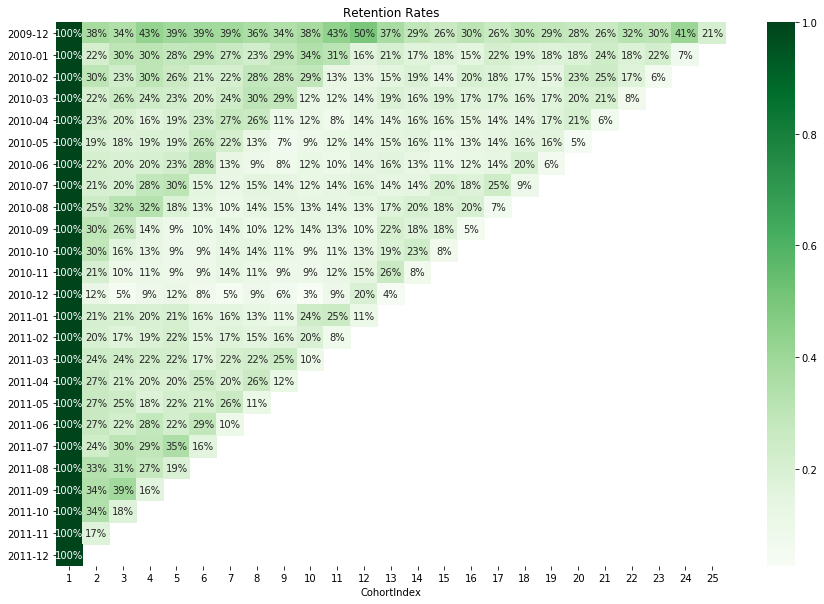

In [142]:
plt.figure(figsize=(15, 10))
plt.title('Retention Rates')
sns.heatmap(data=retention, fmt='.0%', annot=True, cmap='Greens')
plt.show()

In [144]:
average_purchase_size_fin.index = average_purchase_size_fin.index.strftime('%Y-%m')

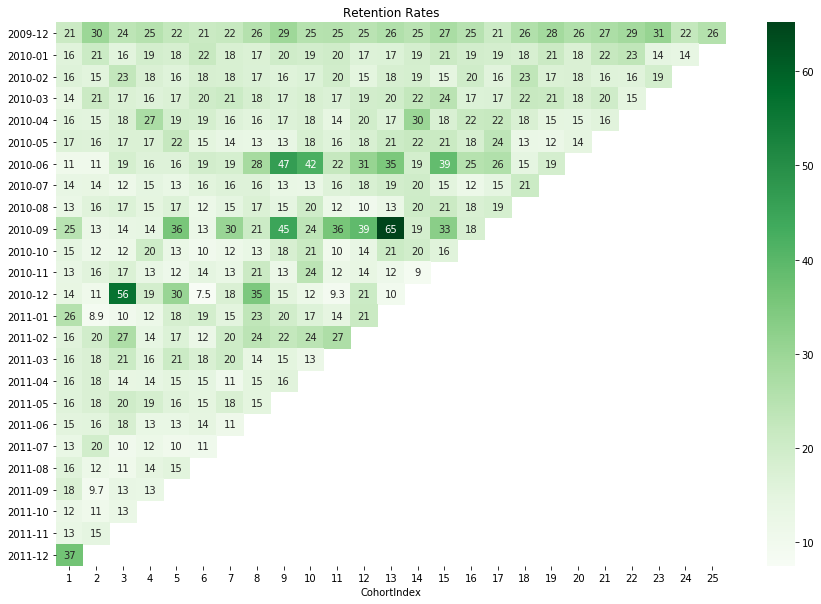

In [145]:
plt.figure(figsize=(15, 10))
plt.title('Retention Rates')
sns.heatmap(data=average_purchase_size_fin, annot=True, cmap='Greens')
plt.show()

## Credentials:

**Data Source:** Online Retail II Data Set, UCI Machine Learning Repository, http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Analysis done after completing the course "Customer Segmentation in Python" on DataCamp (instructor - 
Karolis Urbonas)
